In [2]:
!pip install opendatasets --upgrade --quiet

import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: basanikhilesh
Your Kaggle Key: ··········


100%|██████████| 395M/395M [00:05<00:00, 74.3MB/s]

In [3]:
import os
DATA_DIR = './animefacedataset'

In [4]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [5]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

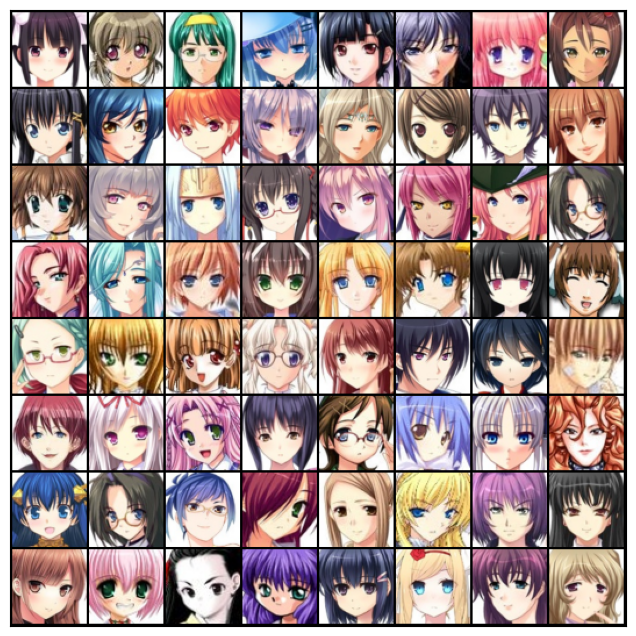

In [7]:
show_batch(train_dl)

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cuda')

In [10]:
train_dl = DeviceDataLoader(train_dl, device)

In [11]:
import torch.nn as nn

discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [12]:
discriminator = to_device(discriminator, device)

In [13]:
latent_size = 128

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


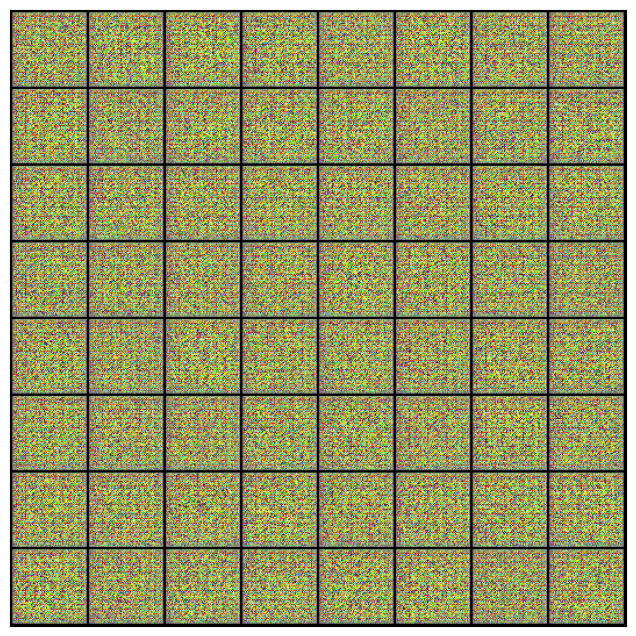

In [14]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [15]:
generator = to_device(generator, device)

In [16]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [17]:
from torchvision.utils import save_image

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [23]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [24]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [25]:
lr = 0.0003
epochs = 40

history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 2.8510, loss_d: 0.3808, real_score: 0.7544, fake_score: 0.0537
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 3.6247, loss_d: 0.1620, real_score: 0.9080, fake_score: 0.0561
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 7.0762, loss_d: 0.3029, real_score: 0.9391, fake_score: 0.1972
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 6.5988, loss_d: 0.1535, real_score: 0.9394, fake_score: 0.0756
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 11.2700, loss_d: 0.4663, real_score: 0.9545, fake_score: 0.2889
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 14.1630, loss_d: 0.7286, real_score: 0.9968, fake_score: 0.4484
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 5.4873, loss_d: 0.1488, real_score: 0.9219, fake_score: 0.0515
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 5.9502, loss_d: 0.0438, real_score: 0.9843, fake_score: 0.0232
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 5.9771, loss_d: 0.0824, real_score: 0.9401, fake_score: 0.0120
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 7.4635, loss_d: 0.0884, real_score: 0.9762, fake_score: 0.0467
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 11.8217, loss_d: 0.3987, real_score: 0.8237, fake_score: 0.0000
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 5.1894, loss_d: 0.0714, real_score: 0.9881, fake_score: 0.0551
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 8.2530, loss_d: 0.1044, real_score: 0.9915, fake_score: 0.0831
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 5.4377, loss_d: 0.0331, real_score: 0.9757, fake_score: 0.0060
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 9.1178, loss_d: 0.0396, real_score: 0.9994, fake_score: 0.0344
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 7.5114, loss_d: 0.0763, real_score: 0.9731, fake_score: 0.0362
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 7.0735, loss_d: 0.0699, real_score: 0.9870, fake_score: 0.0538
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 10.2627, loss_d: 0.0432, real_score: 0.9910, fake_score: 0.0293
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 8.4840, loss_d: 0.0569, real_score: 0.9524, fake_score: 0.0021
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 11.1946, loss_d: 0.0872, real_score: 0.9621, fake_score: 0.0218
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 5.7132, loss_d: 0.1026, real_score: 0.9644, fake_score: 0.0471
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 9.0550, loss_d: 0.1736, real_score: 0.9581, fake_score: 0.1010
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 30.5424, loss_d: 1.1935, real_score: 0.9999, fake_score: 0.3947
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 8.2574, loss_d: 0.0744, real_score: 0.9692, fake_score: 0.0376
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 27.8702, loss_d: 0.3004, real_score: 1.0000, fake_score: 0.1567
Saving generated-images-0025.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [26/40], loss_g: 12.2978, loss_d: 0.4480, real_score: 0.7605, fake_score: 0.0000
Saving generated-images-0026.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [27/40], loss_g: 6.5296, loss_d: 0.1453, real_score: 0.9574, fake_score: 0.0743
Saving generated-images-0027.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [28/40], loss_g: 5.3946, loss_d: 0.0770, real_score: 0.9569, fake_score: 0.0180
Saving generated-images-0028.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [29/40], loss_g: 29.2135, loss_d: 0.1539, real_score: 0.9650, fake_score: 0.0712
Saving generated-images-0029.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [30/40], loss_g: 7.0111, loss_d: 0.0892, real_score: 0.9731, fake_score: 0.0559
Saving generated-images-0030.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [31/40], loss_g: 14.1481, loss_d: 0.1184, real_score: 0.9988, fake_score: 0.0814
Saving generated-images-0031.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [32/40], loss_g: 6.3643, loss_d: 0.0730, real_score: 0.9502, fake_score: 0.0140
Saving generated-images-0032.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [33/40], loss_g: 6.7874, loss_d: 0.0196, real_score: 0.9939, fake_score: 0.0130
Saving generated-images-0033.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [34/40], loss_g: 5.6903, loss_d: 0.0494, real_score: 0.9791, fake_score: 0.0261
Saving generated-images-0034.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [35/40], loss_g: 33.2987, loss_d: 0.0008, real_score: 0.9992, fake_score: 0.0000
Saving generated-images-0035.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [36/40], loss_g: 13.3144, loss_d: 0.0080, real_score: 0.9992, fake_score: 0.0068
Saving generated-images-0036.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [37/40], loss_g: 10.9015, loss_d: 0.0105, real_score: 0.9909, fake_score: 0.0006
Saving generated-images-0037.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [38/40], loss_g: 25.1038, loss_d: 0.0073, real_score: 0.9994, fake_score: 0.0065
Saving generated-images-0038.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [39/40], loss_g: 6.7795, loss_d: 0.0414, real_score: 0.9891, fake_score: 0.0262
Saving generated-images-0039.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [40/40], loss_g: 6.2654, loss_d: 0.0449, real_score: 0.9833, fake_score: 0.0245
Saving generated-images-0040.png


In [26]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

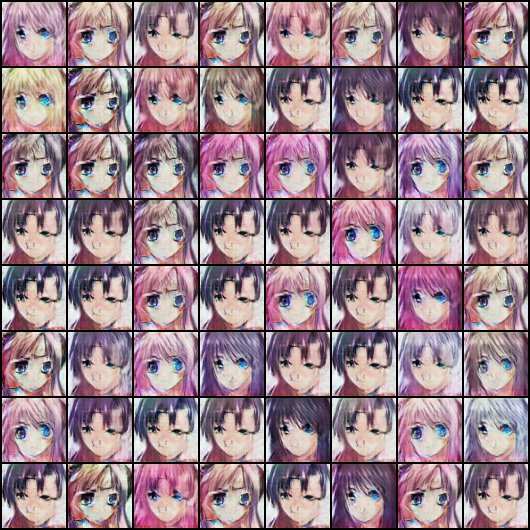

In [27]:
from IPython.display import Image
Image('./generated/generated-images-0040.png')

In [29]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()